In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
from astropy.io import fits
from sklearn.cluster import KMeans

import sys
sys.path.append('/Users/kulkarniad/utils_rh/') # RH util functions
from rh import *

In [2]:
NX = 252
NY = 252
NZ = 64
NLAMBDA = 257


# Load simulation and inversion arrays

In [3]:
d1 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_t.fits')
d2 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_p.fits')
d3 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_pe.fits')
d4 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_vlos.fits')
d5 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_z.fits')
d6 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_vmic.fits')
d7 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_rho.fits')

# Throw away bottom of the atmosphere (stuff nan's out beyond log tau = 1.4)
cut_index = 6

cube_t = d1[0].data[:,:,cut_index:NZ]  
cube_p = d2[0].data[:,:,cut_index:NZ] 
cube_pe = d3[0].data[:,:,cut_index:NZ] 
cube_vlos = d4[0].data[:,:,cut_index:NZ] 
cube_z = d5[0].data[:,:,cut_index:NZ] 
cube_vmic = d6[0].data[:,:,cut_index:NZ] 
cube_rho = d7[0].data[:,:,cut_index:NZ] 

 

In [4]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((NZ,NY,NX)))

In [5]:
sim_z = np.loadtxt('/Users/kulkarniad/sir_inversions/2_line_run/z_100.csv') #km

mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0


In [6]:
sim_tau = np.log10(readsim('/Users/kulkarniad/sir_inversions/2_line_run/tau_100.csv')[:,:,1:])
sim_temp = readsim('/Users/kulkarniad/sir_inversions/2_line_run/t_100.csv')
sim_tau = np.append(np.zeros((NX,NY,1))-6.0,sim_tau,axis=2) ## append log tau = -6 a

In [7]:
raw_spectra = np.loadtxt('/Users/kulkarniad/sir_inversions/2_line_run/spectrum.csv')
raw_spectra = np.transpose(raw_spectra.reshape((NLAMBDA,NY,NX)))

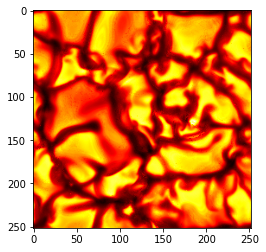

In [8]:
plt.imshow(cube_t[:,:,10],cmap='hot')

In [9]:
tau_sir = np.linspace(1.4,-4.3,num=58) # again we're throwing away the bottom values of tau in SIR inversions

# Now do clustering on spectra

In [10]:
N_CLUSTERS = 5

In [11]:
kmeans_raw = KMeans(n_clusters=N_CLUSTERS,init = 'k-means++' , random_state=5).fit(raw_spectra.reshape((NX*NY,NLAMBDA)))

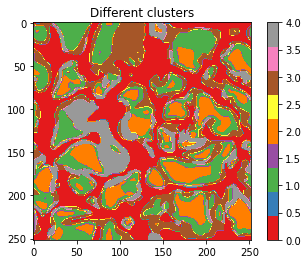

In [12]:
plt.imshow(kmeans_raw.labels_.reshape((NX,NY)),cmap='Set1')
plt.colorbar()
plt.title('Different clusters')
plt.show()

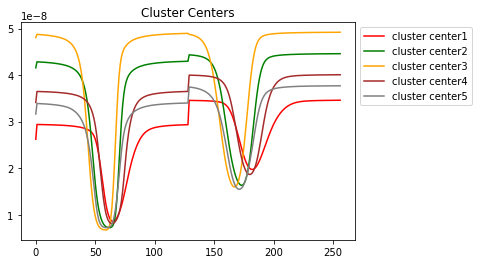

In [13]:
colors = ['red','green', 'orange', 'brown','grey']
for i in np.arange(N_CLUSTERS):
    plt.plot(kmeans_raw.cluster_centers_[i],label = 'cluster center' + str(i+1),color = colors[i])
    plt.legend()
plt.title('Cluster Centers')
plt.legend(bbox_to_anchor=(1, 0, 0, 1))

# Construct average z vs tau for each cluster

In [14]:
cluster_labels = kmeans_raw.labels_.reshape((NX,NY))
counts = np.zeros(N_CLUSTERS)

for i in range(N_CLUSTERS):
    counts[i] = np.count_nonzero(kmeans_raw.labels_.flatten() == i)


In [15]:
# add up tau profiles acoording to cluster classification
for i in range(NX):
    for j in range(NY):
        for c in range(N_CLUSTERS):
            if cluster_labels[i,j] == c:
                tau_clusters[c] += sim_tau[i,j,:]


# divide by number of pixels in each class and plot:
for c in range(N_CLUSTERS):
    tau_clusters[c] /= counts[c]
    plt.plot(sim_z,tau_clusters[c],label = 'cluster ' + str(c))
plt.legend()
plt.xlabel('height (cm)')
plt.ylabel('tau')
plt.title('tau vs height for each cluster')
plt.show()

NameError: name 'tau_clusters' is not defined

# Now interpolate the entire SIR cube

In [ ]:
# create interpolating functions for tau(z)
tau_z = []
for c in range(N_CLUSTERS):
    function = interp1d(sim_z[:],tau_clusters[c],kind='linear',fill_value='extrapolate')
    tau_z.append(function)

In [ ]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vlos = np.zeros((NX,NY,NZ))  
recons_p = np.zeros((NX,NY,NZ))  
recons_pe = np.zeros((NX,NY,NZ))  
recons_vmic = np.zeros((NX,NY,NZ))  
recons_rho = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate') 
        vlos_tau = interp1d(tau_sir,cube_vlos[i,j,:],fill_value='extrapolate') 
        p_tau = interp1d(tau_sir,cube_p[i,j,:],fill_value='extrapolate') 
        pe_tau = interp1d(tau_sir,cube_pe[i,j,:],fill_value='extrapolate') 
        vmic_tau =  interp1d(tau_sir,cube_vmic[i,j,:],fill_value='extrapolate') 
        rho_tau = interp1d(tau_sir,cube_rho[i,j,:],fill_value='extrapolate') 

        # STEP2: Now fill in pixels with interpolated values
        for c in range(N_CLUSTERS):
            #print(c)
            #print(cluster_labels[i,j] == c)
            if cluster_labels[i,j] == c:
                recons_temp[i,j] = temp_tau(tau_z[c](sim_z))
                recons_vlos[i,j] = vlos_tau(tau_z[c](sim_z))
                recons_p[i,j] = p_tau(tau_z[c](sim_z))
                recons_pe[i,j] = pe_tau(tau_z[c](sim_z))
                recons_rho[i,j] = rho_tau(tau_z[c](sim_z))
                
# clean up and smooth

#Calculate derived quantites and put into RH units:
recons_nh = recons_rho/(mu*amu)*(1e6)
recons_vz = recons_vlos*(1e-5)*(-1.0)
recons_nelec = recons_pe/(recons_temp*kb)*(1e6)
recons_vmic *= (1e-5)

#set thresholds

recons_temp[recons_temp < 4500.0] = 4500.0
recons_temp[recons_temp > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e17] =  1e17
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

# Apply a horizontal gaussian filter in the atmosphere:


smoothing = 3

recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose()
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose()
recons_p = gaussian_filter(recons_p,(smoothing,smoothing,0)).transpose()
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose()
recons_vmic = gaussian_filter(recons_vmic,(smoothing,smoothing,0)).transpose()
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose()

cutout = 50

recons_temp = recons_temp[:,0:cutout,0:cutout]
recons_vz = recons_vz[:,0:cutout,0:cutout]
recons_p = recons_p[:,0:cutout,0:cutout]
recons_nelec = recons_nelec[:,0:cutout,0:cutout]
recons_vmic = recons_vmic[:,0:cutout,0:cutout]
recons_nh = recons_nh[:,0:cutout,0:cutout]

# 1 write reconstructed atmosphere

In [ ]:
# WRITE ATMOS

sim_atmos = fits.open('small.fits')[1].data[0]
NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((nz, ny, nx))
vy = np.zeros((nz, ny, nx))
vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vx.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vy.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'recons_smooth_30.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('recons_smooth_30.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# 2) Also write a smoother version of MURAM for consistency

In [ ]:
sim_atmos = fits.open('small.fits')[1].data

smoothing = 3
NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[0][5]
dy = sim_atmos[0][6]

z_vals = sim_atmos[0][7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][8],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][9],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][10],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][11],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][12],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, gaussian_filter(sim_atmos[0][13],(0,smoothing,smoothing)).flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,gaussian_filter(sim_atmos[0][14],(0,smoothing,smoothing)).flatten(), p.pack_double)

! rm 'mur_smooth_30.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('mur_smooth_30.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# 3) 

Let's try cheating a bit and using the temperature from the inversion but the tau(z) mapping from the simulation. So we're just playing with half the battle here

In [ ]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vlos = np.zeros((NX,NY,NZ))  
recons_p = np.zeros((NX,NY,NZ))  
recons_pe = np.zeros((NX,NY,NZ))  
recons_vmic = np.zeros((NX,NY,NZ))  
recons_rho = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate') 
        vlos_tau = interp1d(tau_sir,cube_vlos[i,j,:],fill_value='extrapolate') 
        p_tau = interp1d(tau_sir,cube_p[i,j,:],fill_value='extrapolate') 
        pe_tau = interp1d(tau_sir,cube_pe[i,j,:],fill_value='extrapolate') 
        vmic_tau =  interp1d(tau_sir,cube_vmic[i,j,:],fill_value='extrapolate') 
        rho_tau = interp1d(tau_sir,cube_rho[i,j,:],fill_value='extrapolate') 
        
        # create tau(z) interpolating function for that individual pixel        
        tau_z = interp1d(sim_z,sim_tau[i,j,:],fill_value='extrapolate')
        
        recons_temp[i,j] = temp_tau(tau_z(sim_z))
        recons_vlos[i,j] = vlos_tau(tau_z(sim_z))
        recons_p[i,j] = p_tau(tau_z(sim_z))
        recons_pe[i,j] = pe_tau(tau_z(sim_z))
        recons_rho[i,j] = rho_tau(tau_z(sim_z))


#Calculate derived quantites and put into RH units:
recons_nh = recons_rho/(mu*amu)*(1e6)
recons_vz = recons_vlos*(1e-5)*(-1.0)
recons_nelec = recons_pe/(recons_temp*kb)*(1e6)
recons_vmic *= (1e-5)

#set thresholds

recons_temp[recons_temp < 4500.0] = 4500.0
recons_temp[recons_temp > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e17] =  1e17
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

# Apply a horizontal gaussian filter in the atmosphere:


smoothing = 3

recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose()
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose()
recons_p = gaussian_filter(recons_p,(smoothing,smoothing,0)).transpose()
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose()
recons_vmic = gaussian_filter(recons_vmic,(smoothing,smoothing,0)).transpose()
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose()

cutout = 50

recons_temp = recons_temp[:,0:cutout,0:cutout]
recons_vz = recons_vz[:,0:cutout,0:cutout]
recons_p = recons_p[:,0:cutout,0:cutout]
recons_nelec = recons_nelec[:,0:cutout,0:cutout]
recons_vmic = recons_vmic[:,0:cutout,0:cutout]
recons_nh = recons_nh[:,0:cutout,0:cutout]

# Looks good now write the atmosphere

In [ ]:
# write reconstuced atmosphere

sim_atmos = fits.open('small.fits')[1].data[0]
NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((nz, ny, nx))
vy = np.zeros((nz, ny, nx))
vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vx.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vy.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'recons_smooth_truetau_30.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('recons_smooth_truetau_30.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# Now use simulation temperatures/densities but used clustered tau(z) mapping

In [28]:
#load in MURAM data

sim = Atmos('/Users/kulkarniad/sir_inversions/2_line_run/muram_100.fits')


In [29]:
# create interpolating functions for tau(z)
tau_z = []
for c in range(N_CLUSTERS):
    function = interp1d(sim_z[:],tau_clusters[c],kind='linear',fill_value='extrapolate')
    tau_z.append(function)

NameError: name 'N_CLUSTERS' is not defined

In [30]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vz = np.zeros((NX,NY,NZ))  
recons_nh = np.zeros((NX,NY,NZ))  
recons_nelec = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        
        temp_tau = interp1d(sim_tau[i,j],sim.t[:,i,j],fill_value='extrapolate') 
        vz_tau = interp1d(sim_tau[i,j],sim.vz[:,i,j],fill_value='extrapolate') 
        nelec_tau = interp1d(sim_tau[i,j],sim.nelec[:,i,j],fill_value='extrapolate') 
        nh_tau = interp1d(sim_tau[i,j],sim.nh[:,i,j],fill_value='extrapolate') 

        # STEP2: Now fill in pixels with interpolated values
        for c in range(N_CLUSTERS):
            #print(c)
            #print(cluster_labels[i,j] == c)
            if cluster_labels[i,j] == c:
                recons_temp[i,j] = temp_tau(tau_z[c](sim_z))
                recons_vz[i,j] = vz_tau(tau_z[c](sim_z))
                recons_nh[i,j] = nh_tau(tau_z[c](sim_z))
                recons_nelec[i,j] = nelec_tau(tau_z[c](sim_z))

# transpose arrays:

smoothing = 3
recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose(2,0,1)
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose(2,0,1)


cutout = 50

recons_temp = recons_temp[:,0:cutout,0:cutout]
recons_vz = recons_vz[:,0:cutout,0:cutout]
recons_p = recons_p[:,0:cutout,0:cutout]
recons_nelec = recons_nelec[:,0:cutout,0:cutout]
recons_vmic = recons_vmic[:,0:cutout,0:cutout]
recons_nh = recons_nh[:,0:cutout,0:cutout]

NameError: name 'N_CLUSTERS' is not defined

In [52]:
# WRITE ATMOS

sim_atmos = fits.open('small.fits')[1].data[0]
NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((nz, ny, nx))
vy = np.zeros((nz, ny, nx))
vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vx.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vy.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'recons_smooth_true_temp_30.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('recons_smooth_truetemp_30.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# 4) Test to see if my code is accurate

In [31]:
# reconstruction code + original atmosphere

In [32]:
sim.t.shape

(64, 252, 252)

In [33]:
#load in MURAM data

sim = Atmos('/Users/kulkarniad/sir_inversions/2_line_run/muram_100.fits')

In [34]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vz = np.zeros((NX,NY,NZ))  
recons_nh = np.zeros((NX,NY,NZ))  
recons_nelec = np.zeros((NX,NY,NZ))  

              
for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        temp_tau = interp1d(sim_tau[i,j],sim.t[:,j,i],fill_value='extrapolate') 
        vlos_tau = interp1d(sim_tau[i,j],sim.vz[:,j,i],fill_value='extrapolate') 
        nh_tau = interp1d(sim_tau[i,j],sim.nh[:,j,i],fill_value='extrapolate') 
        nelec_tau = interp1d(sim_tau[i,j],sim.nelec[:,j,i],fill_value='extrapolate') 
        vmic_tau =  interp1d(sim_tau[i,j],sim.vturb[:,j,i],fill_value='extrapolate') 
        
        # create tau(z) interpolating function for that individual pixel        
        tau_z = interp1d(sim_z,sim_tau[i,j,:],fill_value='extrapolate')
        
        recons_temp[i,j] = temp_tau(tau_z(sim_z))
        recons_vz[i,j] = vlos_tau(tau_z(sim_z))
        recons_nh[i,j] = nh_tau(tau_z(sim_z))
        recons_nelec[i,j] = nelec_tau(tau_z(sim_z))

                
# transpose arrays:

smoothing = 3
recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose(2,0,1)
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose(2,0,1)

cutout = 50

recons_temp = recons_temp[:,0:cutout,0:cutout]
recons_vz = recons_vz[:,0:cutout,0:cutout]
recons_p = recons_p[:,0:cutout,0:cutout]
recons_nelec = recons_nelec[:,0:cutout,0:cutout]
recons_vmic = recons_vmic[:,0:cutout,0:cutout]
recons_nh = recons_nh[:,0:cutout,0:cutout]

NameError: name 'recons_p' is not defined

In [ ]:
# WRITE ATMOS

sim_atmos = fits.open('small.fits')[1].data[0]
NHydr = 1
nx = 50
ny = 50
nz = 64

dx = sim_atmos[5]  
dy = sim_atmos[6]

z_vals = sim_atmos[7]

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((nz, ny, nx))
vy = np.zeros((nz, ny, nx))
vmic = np.zeros((nz, ny, nx))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(nx)
p.pack_int(ny)
p.pack_int(nz)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(dx)
p.pack_double(dy)

p.pack_farray(nz, z_vals, p.pack_double)
p.pack_farray(nz*ny*nx, recons_temp.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_nelec.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vmic.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vx.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, vy.flatten(), p.pack_double)
p.pack_farray(nz*ny*nx, recons_vz.flatten(), p.pack_double)
p.pack_farray(NHydr*nz*ny*nx,recons_nh.flatten(), p.pack_double)

! rm 'recons_code_30.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('recons_code_30.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# Set velocity = 0 and try

In [35]:
recons_vz

array([[[ 3.93609293e-02,  2.76771338e-02,  4.58958562e-03, ...,
          2.81623813e-01,  2.58296303e-01,  2.36463497e-01],
        [ 1.30815452e-02,  2.06278047e-03, -1.97257213e-02, ...,
          2.75530571e-01,  2.52177803e-01,  2.30374822e-01],
        [-3.39286534e-02, -4.36858227e-02, -6.30186479e-02, ...,
          2.64274884e-01,  2.40880259e-01,  2.19134528e-01],
        ...,
        [ 1.12603527e-01,  9.22631212e-02,  5.40207597e-02, ...,
         -2.18411527e-01, -2.56290273e-01, -3.07467673e-01],
        [ 1.78561854e-01,  1.57894720e-01,  1.18990799e-01, ...,
         -2.32736416e-01, -2.69616973e-01, -3.18414326e-01],
        [ 2.48505781e-01,  2.27436399e-01,  1.87718530e-01, ...,
         -2.47829330e-01, -2.84039202e-01, -3.30607124e-01]],

       [[ 3.91575175e-02,  2.74955564e-02,  4.44161387e-03, ...,
          2.81150861e-01,  2.57829296e-01,  2.36019456e-01],
        [ 1.28649580e-02,  1.86570776e-03, -1.98931230e-02, ...,
          2.75090194e-01,  2.51740703e